# Import Librairies

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
import os
from datetime import datetime, timedelta
import pmdarima as pm
import pyodbc
import math
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from os.path import exists

# Load data

In [2]:
FILE_PATH = "weather_data_1.xlsx"

In [3]:
dataframe = pd.read_excel(FILE_PATH)
dataframe.head()

dt  temp  pressure  humidity  clouds  wind_speed  wind_deg  \
0  2020-01-01T00:00  14.6    1018.5      75.0    42.0        11.9     194.0   
1  2020-01-01T01:00  14.5    1018.3      75.0    47.0        10.4     194.0   
2  2020-01-01T02:00  14.9    1017.6      72.0    42.0         9.9     199.0   
3  2020-01-01T03:00  15.0    1017.4      71.0    52.0        12.2     199.0   
4  2020-01-01T04:00  14.9    1017.4      73.0    32.0        15.2     194.0   

   season  
0  Winter  
1  Winter  
2  Winter  
3  Winter  
4  Winter

# Data info

In [4]:
dataframe.shape

(45576, 8)

In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45576 entries, 0 to 45575
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dt          45576 non-null  object 
 1   temp        45529 non-null  float64
 2   pressure    45529 non-null  float64
 3   humidity    45529 non-null  float64
 4   clouds      45529 non-null  float64
 5   wind_speed  45529 non-null  float64
 6   wind_deg    45529 non-null  float64
 7   season      45576 non-null  object 
dtypes: float64(6), object(2)
memory usage: 2.8+ MB


In [6]:
dataframe['dt'] = pd.to_datetime(dataframe['dt']) 

In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45576 entries, 0 to 45575
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dt          45576 non-null  datetime64[ns]
 1   temp        45529 non-null  float64       
 2   pressure    45529 non-null  float64       
 3   humidity    45529 non-null  float64       
 4   clouds      45529 non-null  float64       
 5   wind_speed  45529 non-null  float64       
 6   wind_deg    45529 non-null  float64       
 7   season      45576 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 2.8+ MB


In [8]:
df=dataframe.copy()
df.head()

dt  temp  pressure  humidity  clouds  wind_speed  wind_deg  \
0 2020-01-01 00:00:00  14.6    1018.5      75.0    42.0        11.9     194.0   
1 2020-01-01 01:00:00  14.5    1018.3      75.0    47.0        10.4     194.0   
2 2020-01-01 02:00:00  14.9    1017.6      72.0    42.0         9.9     199.0   
3 2020-01-01 03:00:00  15.0    1017.4      71.0    52.0        12.2     199.0   
4 2020-01-01 04:00:00  14.9    1017.4      73.0    32.0        15.2     194.0   

   season  
0  Winter  
1  Winter  
2  Winter  
3  Winter  
4  Winter

In [9]:
df.isnull().sum()

dt             0
temp          47
pressure      47
humidity      47
clouds        47
wind_speed    47
wind_deg      47
season         0
dtype: int64

In [10]:
df = df [["dt","temp","pressure","humidity","clouds","wind_speed","wind_deg"]]
df.head()


dt  temp  pressure  humidity  clouds  wind_speed  wind_deg
0 2020-01-01 00:00:00  14.6    1018.5      75.0    42.0        11.9     194.0
1 2020-01-01 01:00:00  14.5    1018.3      75.0    47.0        10.4     194.0
2 2020-01-01 02:00:00  14.9    1017.6      72.0    42.0         9.9     199.0
3 2020-01-01 03:00:00  15.0    1017.4      71.0    52.0        12.2     199.0
4 2020-01-01 04:00:00  14.9    1017.4      73.0    32.0        15.2     194.0

In [11]:
df.fillna(df.mean(), inplace=True)

In [12]:
df.isnull().sum()

dt            0
temp          0
pressure      0
humidity      0
clouds        0
wind_speed    0
wind_deg      0
dtype: int64

Let's take 3 features to be predicted: the temperature, the humidity and the wind speed.

In [13]:
df = df[df['wind_speed'] > 0]

# Features analysis

In [14]:
import seaborn as sns

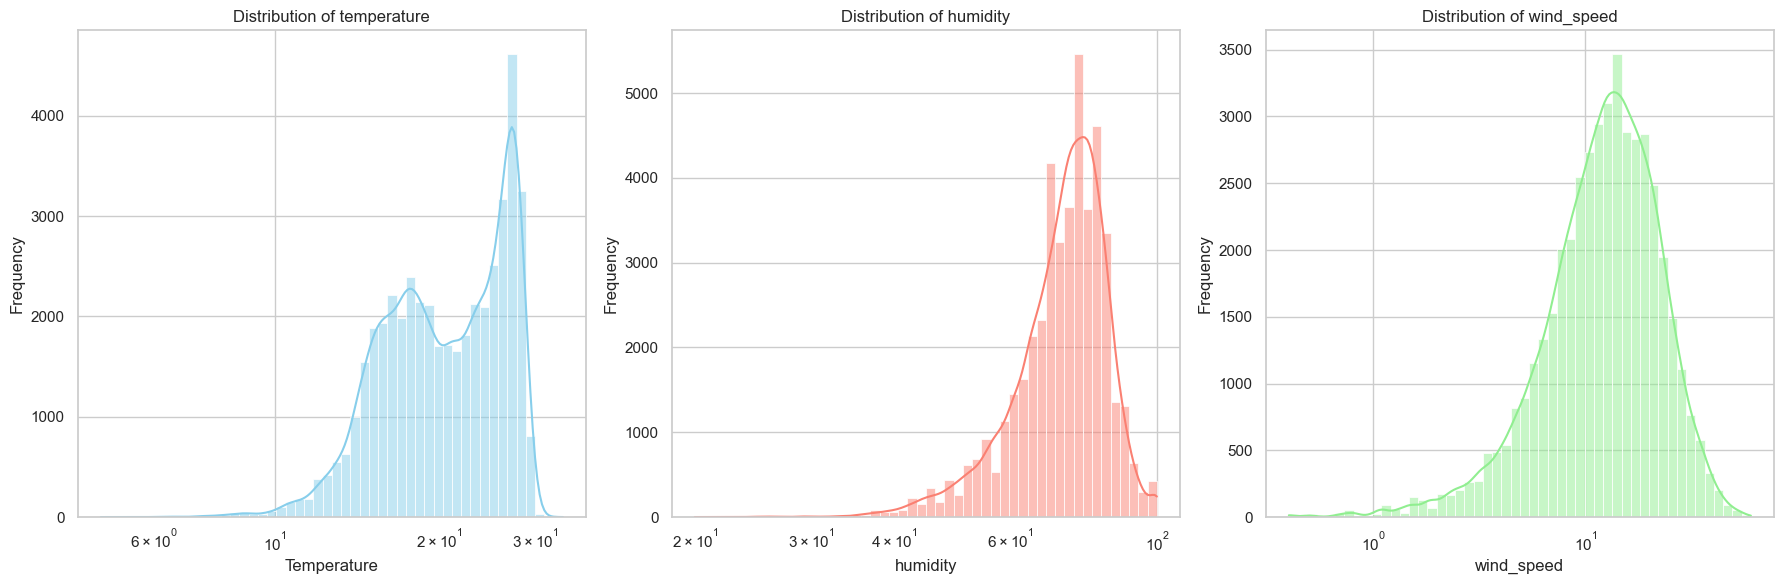

In [15]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(df['temp'], bins=50, kde=True, color='skyblue',log_scale=True)
plt.title('Distribution of temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(df['humidity'], bins=50, kde=True, color='salmon',log_scale=True)
plt.title('Distribution of humidity')
plt.xlabel('humidity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(df['wind_speed'], bins=50, kde=True, color='lightgreen',log_scale=True)
plt.title('Distribution of wind_speed')
plt.xlabel('wind_speed')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Additive and multiplicative models

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
period = 24  # This is for daily seasonality in hourly data

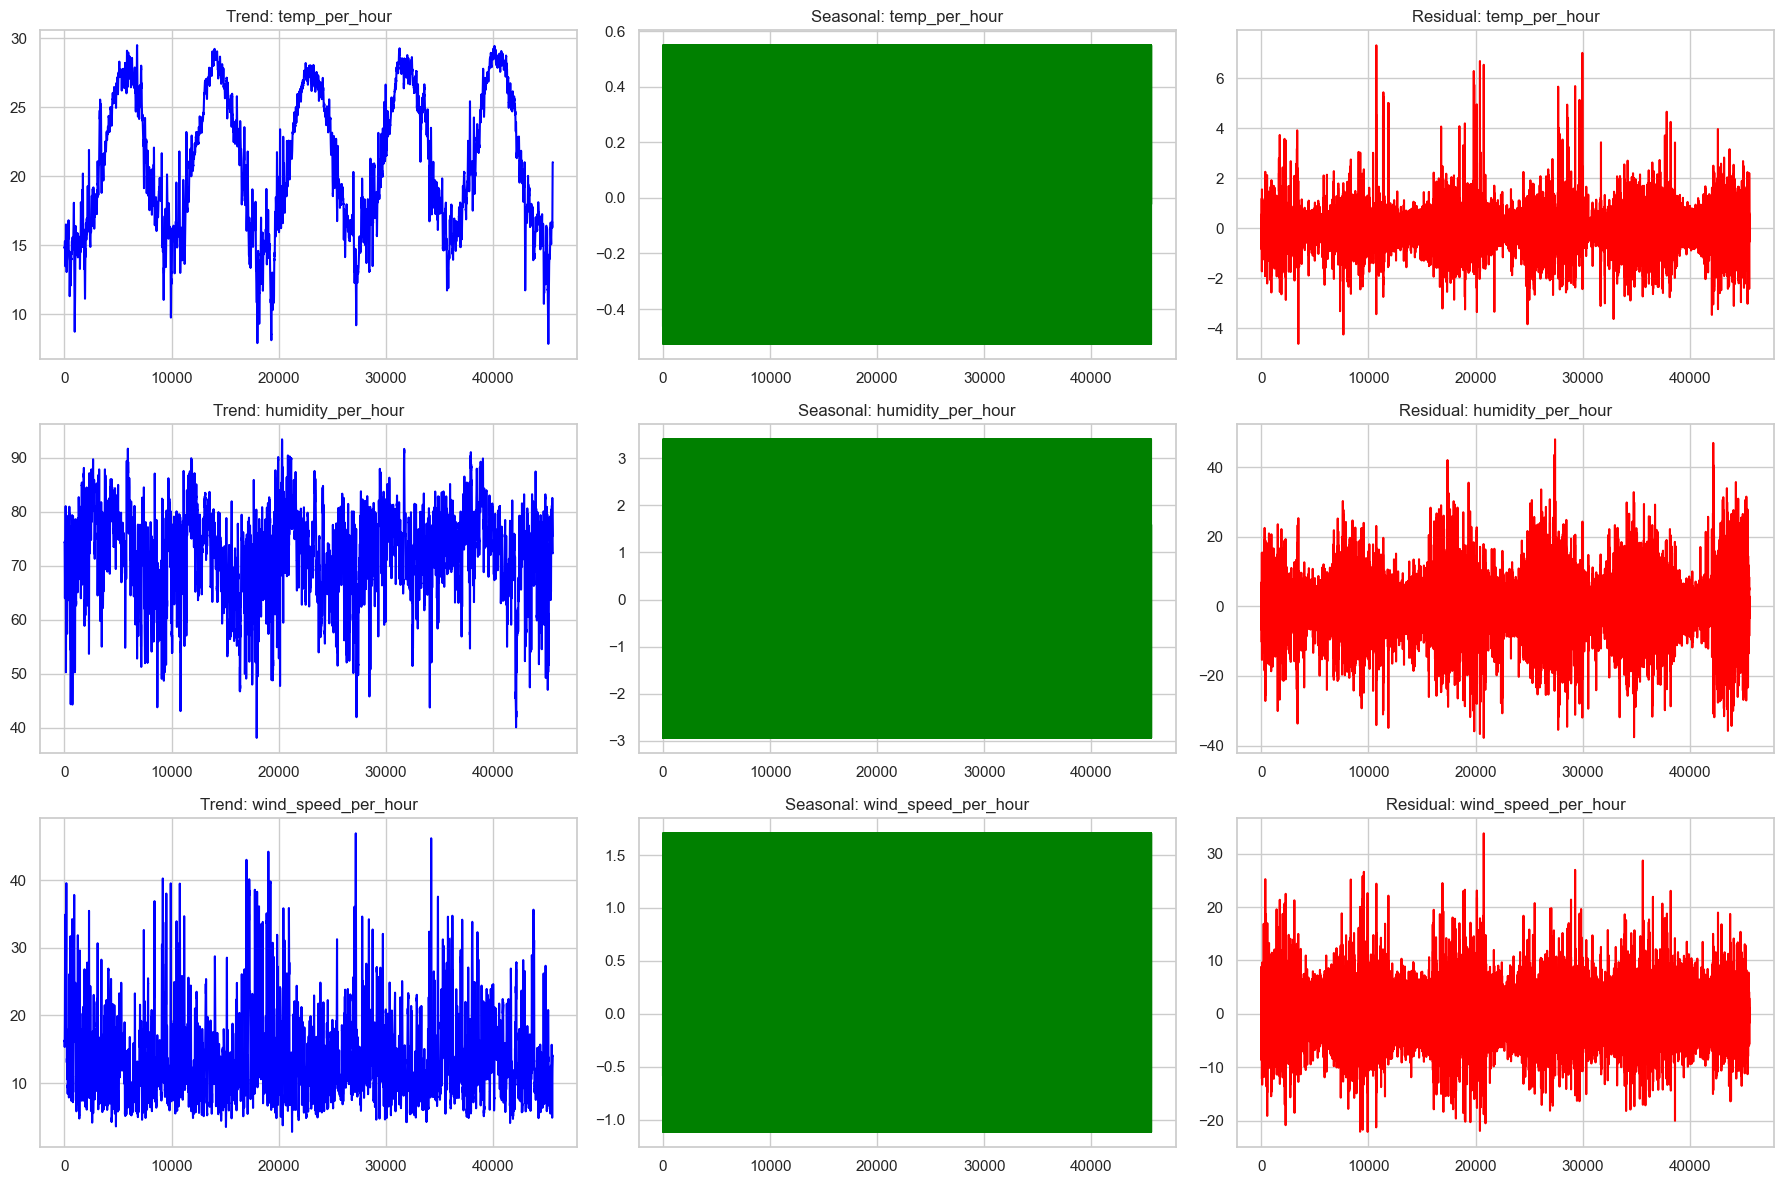

In [18]:
# Decompose each feature using additive model
decompose_temp = seasonal_decompose(df['temp'], model='additive', period=period)
decompose_humidity = seasonal_decompose(df['humidity'], model='additive', period=period)
decompose_wind_speed = seasonal_decompose(df['wind_speed'], model='additive', period=period)

# Plot in a 3x3 grid
plt.figure(figsize=(18, 12))

plt.subplot(3, 3, 1)
plt.plot(decompose_temp.trend, color='blue')
plt.title('Trend: temp_per_hour')

plt.subplot(3, 3, 2)
plt.plot(decompose_temp.seasonal, color='green')
plt.title('Seasonal: temp_per_hour')

plt.subplot(3, 3, 3)
plt.plot(decompose_temp.resid, color='red')
plt.title('Residual: temp_per_hour')

plt.subplot(3, 3, 4)
plt.plot(decompose_humidity.trend, color='blue')
plt.title('Trend: humidity_per_hour')

plt.subplot(3, 3, 5)
plt.plot(decompose_humidity.seasonal, color='green')
plt.title('Seasonal: humidity_per_hour')

plt.subplot(3, 3, 6)
plt.plot(decompose_humidity.resid, color='red')
plt.title('Residual: humidity_per_hour')

plt.subplot(3, 3, 7)
plt.plot(decompose_wind_speed.trend, color='blue')
plt.title('Trend: wind_speed_per_hour')

plt.subplot(3, 3, 8)
plt.plot(decompose_wind_speed.seasonal, color='green')
plt.title('Seasonal: wind_speed_per_hour')

plt.subplot(3, 3, 9)
plt.plot(decompose_wind_speed.resid, color='red')
plt.title('Residual: wind_speed_per_hour')

plt.tight_layout()
plt.show()

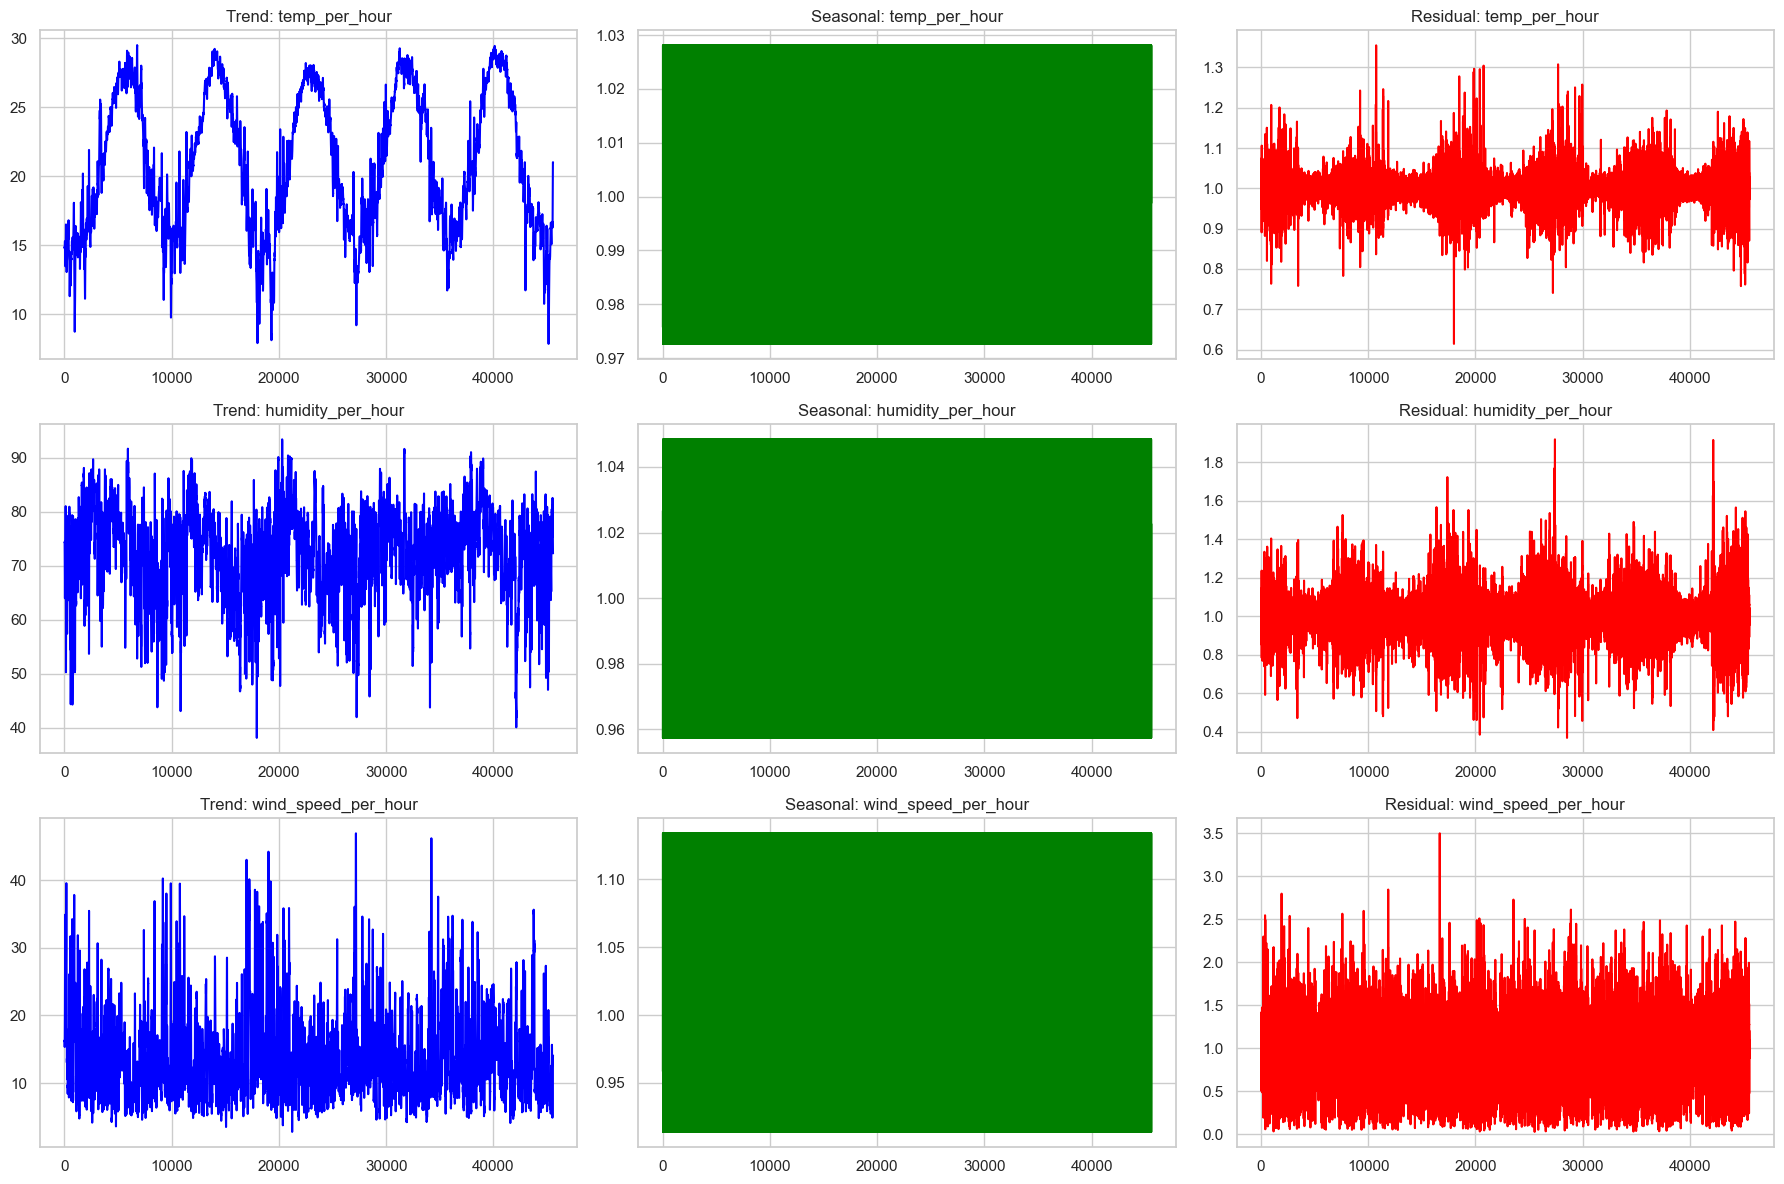

In [19]:
# Decompose each feature using multiplicative model
decompose_temp = seasonal_decompose(df['temp'], model='multiplicative', period=period)
decompose_humidity = seasonal_decompose(df['humidity'], model='multiplicative', period=period)
decompose_wind_speed = seasonal_decompose(df['wind_speed'], model='multiplicative', period=period)

# Plot in a 3x3 grid
plt.figure(figsize=(18, 12))

plt.subplot(3, 3, 1)
plt.plot(decompose_temp.trend, color='blue')
plt.title('Trend: temp_per_hour')

plt.subplot(3, 3, 2)
plt.plot(decompose_temp.seasonal, color='green')
plt.title('Seasonal: temp_per_hour')

plt.subplot(3, 3, 3)
plt.plot(decompose_temp.resid, color='red')
plt.title('Residual: temp_per_hour')

plt.subplot(3, 3, 4)
plt.plot(decompose_humidity.trend, color='blue')
plt.title('Trend: humidity_per_hour')

plt.subplot(3, 3, 5)
plt.plot(decompose_humidity.seasonal, color='green')
plt.title('Seasonal: humidity_per_hour')

plt.subplot(3, 3, 6)
plt.plot(decompose_humidity.resid, color='red')
plt.title('Residual: humidity_per_hour')

plt.subplot(3, 3, 7)
plt.plot(decompose_wind_speed.trend, color='blue')
plt.title('Trend: wind_speed_per_hour')

plt.subplot(3, 3, 8)
plt.plot(decompose_wind_speed.seasonal, color='green')
plt.title('Seasonal: wind_speed_per_hour')

plt.subplot(3, 3, 9)
plt.plot(decompose_wind_speed.resid, color='red')
plt.title('Residual: wind_speed_per_hour')

plt.tight_layout()
plt.show()

# Stationarity detection:

In [20]:
from statsmodels.tsa.stattools import adfuller

In [21]:
def test_stationarity(series):
    result = adfuller(series.dropna())  
    p_value = result[1]
    return p_value < 0.05  # Stationary if p-value < 0.05

In [22]:
df_1 = df[[ 'dt',  'temp']]

df_1.head()

dt  temp
0 2020-01-01 00:00:00  14.6
1 2020-01-01 01:00:00  14.5
2 2020-01-01 02:00:00  14.9
3 2020-01-01 03:00:00  15.0
4 2020-01-01 04:00:00  14.9

In [23]:
df_2 = df[[ 'dt',  'humidity']]

df_2.head()

dt  humidity
0 2020-01-01 00:00:00      75.0
1 2020-01-01 01:00:00      75.0
2 2020-01-01 02:00:00      72.0
3 2020-01-01 03:00:00      71.0
4 2020-01-01 04:00:00      73.0

In [24]:
df_3 = df[[ 'dt',  'wind_speed']]

df_3.head()

dt  wind_speed
0 2020-01-01 00:00:00        11.9
1 2020-01-01 01:00:00        10.4
2 2020-01-01 02:00:00         9.9
3 2020-01-01 03:00:00        12.2
4 2020-01-01 04:00:00        15.2

In [25]:
#df_1.set_index('dt', inplace=True)  

# Test stationarity
df_1_is_stationary = test_stationarity(df_1['temp'])

if df_1_is_stationary:
    print("The temperature time series is stationary.")
else:
    print("The temperature time series is non-stationary.")

The temperature time series is stationary.


In [26]:
df_2.set_index('dt', inplace=True)  

# Test stationarity
df_2_is_stationary = test_stationarity(df_2['humidity'])

if df_2_is_stationary:
    print("The humidity time series is stationary.")
else:
    print("The humidity time series is non-stationary.")

The humidity time series is stationary.


In [27]:
df_3.set_index('dt', inplace=True)  

# Test stationarity
df_3_is_stationary = test_stationarity(df_3['wind_speed'])

if df_3_is_stationary:
    print("The wind_speed time series is stationary.")
else:
    print("The wind_speed time series is non-stationary.")

The wind_speed time series is stationary.


# ACF and PCF

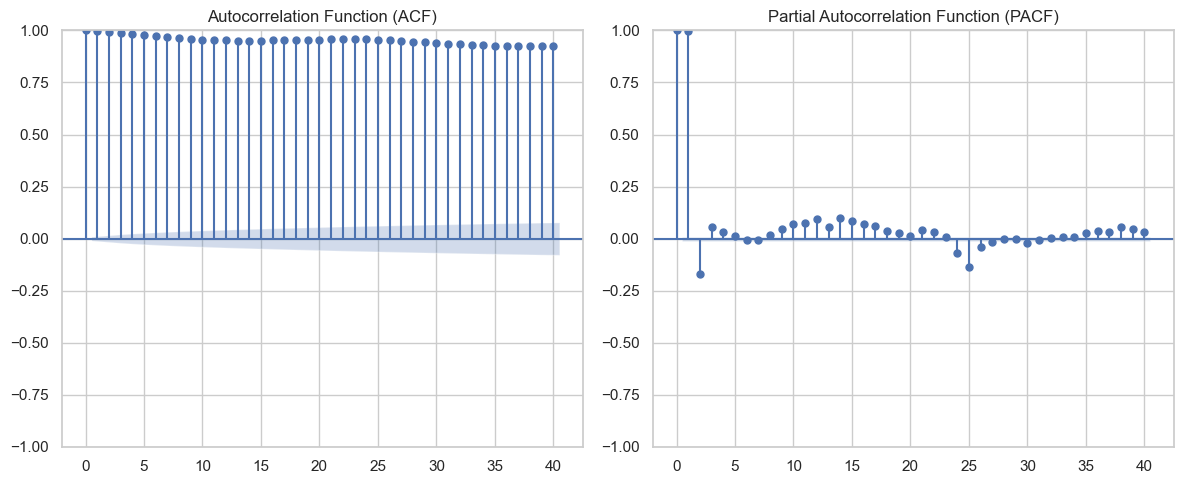

In [28]:

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#
# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Autocorrelation Function (ACF)
plot_acf(df_1['temp'], ax=ax[0], lags=40)  
ax[0].set_title('Autocorrelation Function (ACF)')

# Partial Autocorrelation Function (PACF)
plot_pacf(df_1['temp'], ax=ax[1], lags=40, method="ywm")  
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


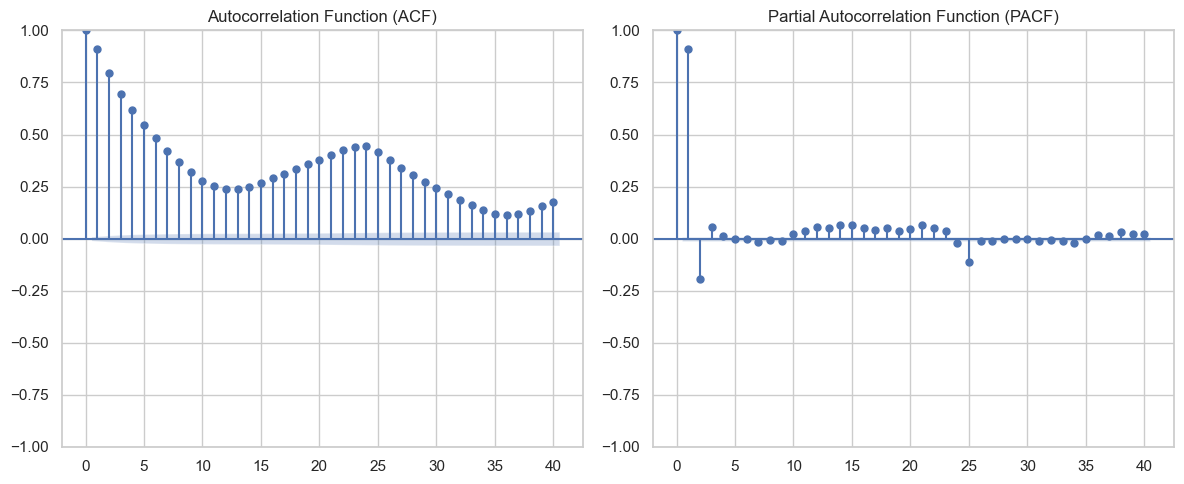

In [29]:
# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Autocorrelation Function (ACF)
plot_acf(df_2['humidity'], ax=ax[0], lags=40)  
ax[0].set_title('Autocorrelation Function (ACF)')

# Partial Autocorrelation Function (PACF)
plot_pacf(df_2['humidity'], ax=ax[1], lags=40, method="ywm")  
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


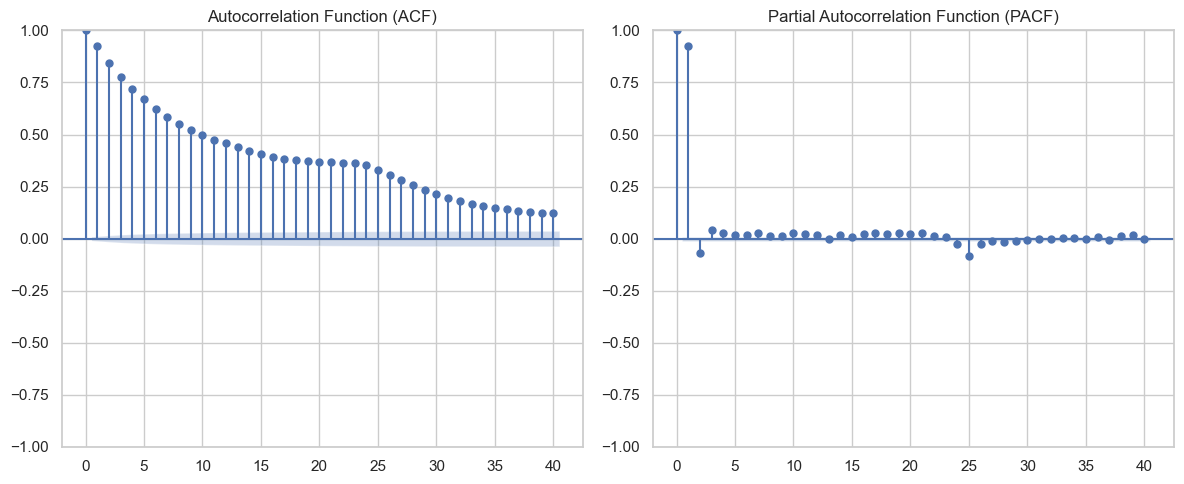

In [30]:
# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Autocorrelation Function (ACF)
plot_acf(df_3['wind_speed'], ax=ax[0], lags=40)  
ax[0].set_title('Autocorrelation Function (ACF)')

# Partial Autocorrelation Function (PACF)
plot_pacf(df_3['wind_speed'], ax=ax[1], lags=40, method="ywm")  
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


# Modeling

C:\Users\ThinkBook\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ThinkBook\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ThinkBook\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                45570
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27114.987
Date:                Wed, 19 Mar 2025   AIC                          54235.973
Time:                        15:47:32   BIC                          54262.154
Sample:                             0   HQIC                         54244.210
                              - 45570                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0556      0.012     -4.561      0.000      -0.080      -0.032
ma.L1          0.2323      0.012     19.844      0.000       0.209       0.255
sigma2         0.1925      0.000    445.696      0.0

C:\Users\ThinkBook\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ThinkBook\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


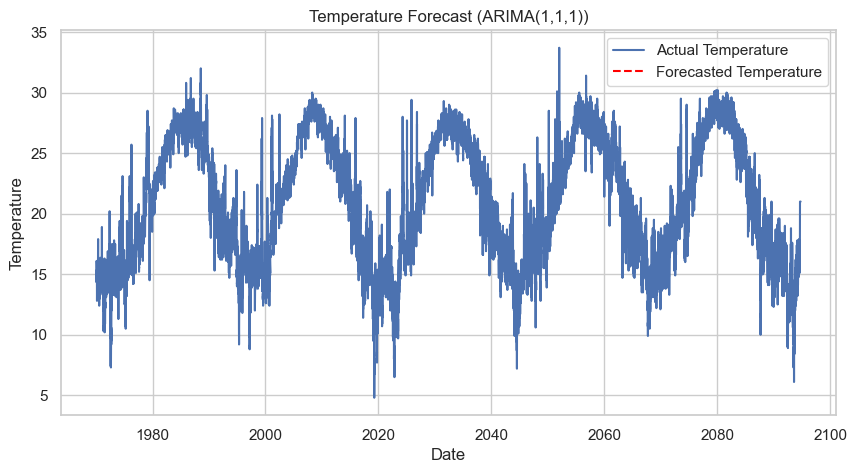

In [36]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_1['temp'], order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())

forecast_steps = 4 * 7 * 24  # 4 weeks * 7 days * 24 hours 
forecast = model_fit.forecast(steps=forecast_steps)


future_dates = pd.date_range(start=df_1.index[-1], periods=forecast_steps+1, freq='H')[1:]

plt.figure(figsize=(10,5))
plt.plot(df_1.index, df_1['temp'], label="Actual Temperature")
plt.plot(future_dates, forecast, label="Forecasted Temperature", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature Forecast (ARIMA(1,1,1))")
plt.legend()
plt.show()


C:\Users\ThinkBook\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ThinkBook\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ThinkBook\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                45570
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27114.987
Date:                Wed, 19 Mar 2025   AIC                          54235.973
Time:                        15:47:43   BIC                          54262.154
Sample:                             0   HQIC                         54244.210
                              - 45570                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0556      0.012     -4.561      0.000      -0.080      -0.032
ma.L1          0.2323      0.012     19.844      0.000       0.209       0.255
sigma2         0.1925      0.000    445.696      0.0

C:\Users\ThinkBook\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ThinkBook\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


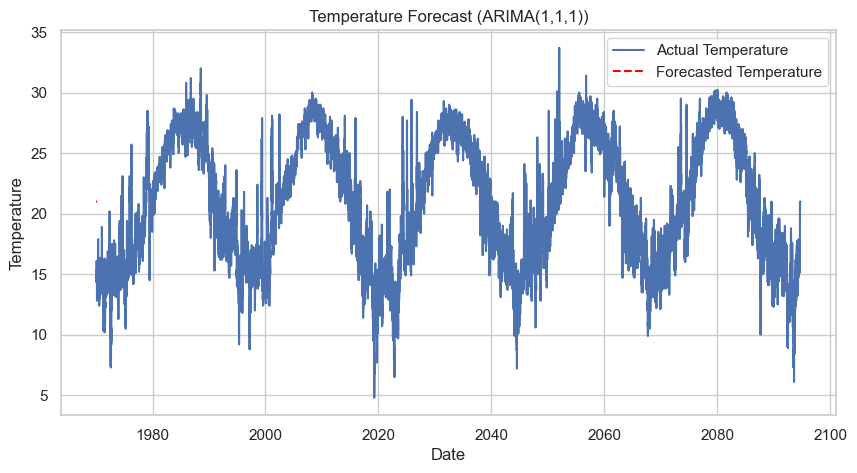

In [37]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_1['temp'], order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())

forecast_steps = 10 * 7 * 24  # 10 weeks * 7 days * 24 hours 
forecast = model_fit.forecast(steps=forecast_steps)


future_dates = pd.date_range(start=df_1.index[-1], periods=forecast_steps+1, freq='H')[1:]

plt.figure(figsize=(10,5))
plt.plot(df_1.index, df_1['temp'], label="Actual Temperature")
plt.plot(future_dates, forecast, label="Forecasted Temperature", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature Forecast (ARIMA(1,1,1))")
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df_1['temp'], 
                order=(1,1,1),       # ARIMA parameters (p,d,q)
                seasonal_order=(1,1,1,24*30),  # Seasonality (P,D,Q,s) - Monthly seasonality
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
model_fit = model.fit()

forecast_steps = 15 * 7 * 24  
forecast = model_fit.forecast(steps=forecast_steps)

# Create future datetime index
future_dates = pd.date_range(start=df_1.index[-1], periods=forecast_steps+1, freq='H')[1:]

# Plot actual vs forecasted values
plt.figure(figsize=(12,6))
plt.plot(df_1.index, df_1['temp'], label="Actual Temperature")
plt.plot(future_dates, forecast, linestyle='dashed', color='red', label="Forecasted Temperature (4 Weeks)")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature Forecast for 4 Weeks using SARIMA")
plt.legend()
plt.grid()
plt.show()

# Model summary
print(model_fit.summary())


C:\Users\ThinkBook\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ThinkBook\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
